# Project 2

Dataset 1: 20180101-20221231 CAISO Real-time Price (every 5 minutes)

Dataset 2: Historical Load in CAISO 2019-2022 (daily)

Target: Comapre Southern California (SP15) Daily Power Price and Load between 2019 and 2022

## Dataset 1

In [64]:
import pandas as pd

prices = pd.read_csv("20180101-20221231 CAISO Real-time Price.csv")
print(prices.head())


                   Date     price      hub
0  1/1/2018 12:00:00 AM  38.89844  TH_NP15
1  1/1/2018 12:00:00 AM  38.85151  TH_SP15
2  1/1/2018 12:00:00 AM  38.51520  TH_ZP26
3  1/1/2018 12:05:00 AM  53.66772  TH_NP15
4  1/1/2018 12:05:00 AM  53.60298  TH_SP15


In [65]:
print(prices['hub'].unique())

['TH_NP15' 'TH_SP15' 'TH_ZP26']


In [67]:
prices = prices.copy()
# Filter SP15 data, which is called "TH_SP15" here
SP15prices = prices[prices['hub'] == "TH_SP15"].copy()

print(SP15prices.head())


                    Date     price      hub
1   1/1/2018 12:00:00 AM  38.85151  TH_SP15
4   1/1/2018 12:05:00 AM  53.60298  TH_SP15
7   1/1/2018 12:10:00 AM  53.60298  TH_SP15
10  1/1/2018 12:15:00 AM  52.87035  TH_SP15
13  1/1/2018 12:20:00 AM  53.19333  TH_SP15


In [81]:
# ensure datetime
SP15prices['Date'] = pd.to_datetime(SP15prices['Date'],format="%m/%d/%Y %I:%M:%S %p")

# set index
SP15 = SP15prices.set_index('Date')

# resample to daily average price
daily_price = SP15['price'].resample('D').mean().reset_index()

print(daily_price.head())
print(daily_price['Date'].dtype)


        Date      price
0 2018-01-01  35.171782
1 2018-01-02  33.484707
2 2018-01-03  81.572158
3 2018-01-04  44.387097
4 2018-01-05  60.596711
datetime64[ns]


## Dataset 2

In [72]:
load = pd.read_csv("Clean2HistoricLoad19-22.csv")
print(load.head())


         Date   HE            PGE            SCE          SDGE          VEA  \
0  2019-01-01  276  226726.052365  226652.600742  48485.355385  2228.305865   
1  2019-01-02  300  260691.911792  261546.681339  56532.901573  2351.032335   
2  2019-01-03  300  265868.411141  271765.918291  57024.675624  2277.753371   
3  2019-01-04  300  262044.660342  268768.426374  56456.888148  2154.733265   
4  2019-01-05  300  260399.809403  259987.945379  55838.513720  2173.155738   

     CAISO Total  
0  504092.314960  
1  581122.532202  
2  596936.763676  
3  589424.710454  
4  578399.423713  


In [79]:
# Filter SP15 load data, where SP15 includes SCE and SDGE
## SCE: Southern California Edison
## SDGE: San Diego Gas & Electric

load['SP15_load'] = load['SCE'] + load['SDGE']

sp15_load = load[['Date', 'SP15_load']].copy()

sp15_load['Date'] = pd.to_datetime(sp15_load['Date'],format="%Y-%m-%d")

print(sp15_load.head())
print(sp15_load['Date'].dtype)


        Date      SP15_load
0 2019-01-01  275137.956127
1 2019-01-02  318079.582912
2 2019-01-03  328790.593914
3 2019-01-04  325225.314522
4 2019-01-05  315826.459099
datetime64[ns]


## Merging Data

In [82]:
merged = pd.merge(daily_price, sp15_load, on='Date', how='inner')

print(merged.head())
print(merged.shape)


        Date      price      SP15_load
0 2019-01-01  33.044370  275137.956127
1 2019-01-02  38.073193  318079.582912
2 2019-01-03  38.878668  328790.593914
3 2019-01-04  42.542135  325225.314522
4 2019-01-05  61.861529  315826.459099
(1461, 3)


In [84]:
merged = merged.rename(columns={'price':'SP15_price', 'SP15_load':'SP15_load'})
merged.isna().sum()
merged = merged.dropna()
print(merged.shape)

(1461, 3)


## Plotting Data

<Figure size 1200x500 with 0 Axes>

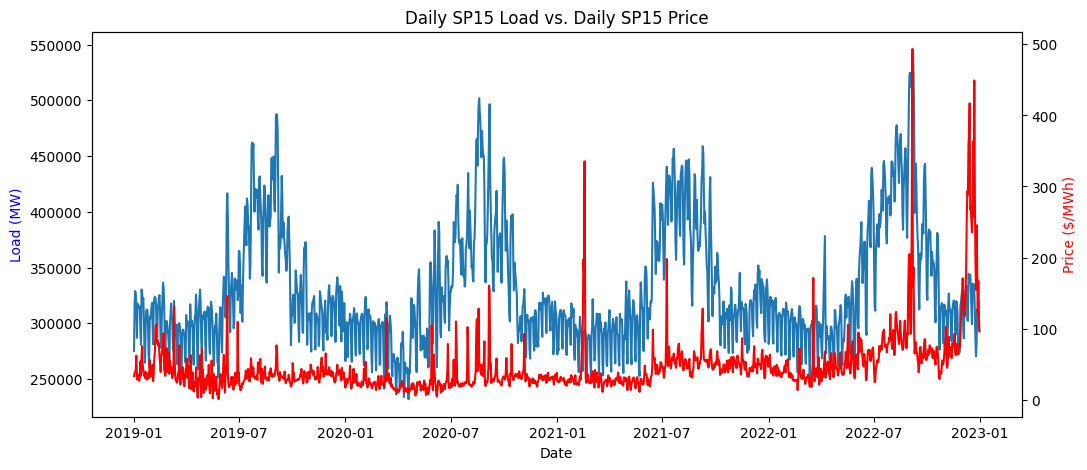

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# First axis: Load
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(merged['Date'], merged['SP15_load'], label='SP15 Load (MW)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Load (MW)', color='blue')

# Second axis: Price
ax2 = ax1.twinx()
ax2.plot(merged['Date'], merged['SP15_price'], color='red', label='SP15 Price ($/MWh)')
ax2.set_ylabel('Price ($/MWh)', color='red')

plt.title('Daily SP15 Load vs. Daily SP15 Price')
plt.show()


## Takeaway

Load and price generally move together. Periods with higher SP15 load tend to correspond to higher daily average prices, reflecting the typical supply–demand dynamics in CAISO: when demand increases, more expensive marginal units set the clearing price.

Seasonal patterns are visible.Summer months (especially July–September) show both the highest loads and the highest price levels. This is consistent with air-conditioning demand and tighter reserve margins in SP15.

Price spikes do not always align perfectly with load peaks. Several sharp price spikes occur on days when load is not exceptionally high. These likely reflect short-term scarcity, gas price volatility, renewable output drops, or congestion events, showing that load is not the only driver of daily price volatility.

Load is smoother; price is much more volatile. Daily SP15 load fluctuates within a relatively predictable seasonal band, while prices show high variability and sudden spikes. This illustrates why electricity markets require flexible resources and hedging mechanisms.

Overall correlation exists but is not perfect. The combined plot shows a noticeable positive relationship between demand and prices, but with structural deviations. This highlights that system conditions, fuel costs, and renewables also play major roles in CAISO price formation.
